In [1]:
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import cv2
import keras_ocr
import os

import re
import six
import math
import lmdb

from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

## 데이터셋 불러오기

In [2]:
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


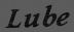

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


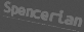

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


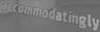

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


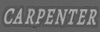

In [3]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [4]:
### 영어 및 숫자 인식을 위한 Target 생성
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

In [5]:
from tensorflow.keras.utils import Sequence

class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            # 이미지 사이즈 조정
            # height을 img_size[1]으로 조정했을 때, 같은 비율로 width로 조정
            # 조정된 width가 img_size[0] (100)보다 작으면 조정된 width 선택
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            
            # img를 target_img_size만큼 resize
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            
            # label 조정
            # 대문자화, 불용어 제거, 텍스트 길이 제한
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [6]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label


label_converter = LabelConverter(TARGET_CHARACTERS)
encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Recognition 모델 구성

In [7]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
# crnn model
# input : (100,32,3)
# 
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # CNN (64, 128, 256x2, 512x2) + (512)
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    # RNN 
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = tf.keras.Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [9]:
model = build_crnn_model()

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

## Recognition 모델 학습

In [11]:
# train, validation dataset
label_converter = LabelConverter(TARGET_CHARACTERS)
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

# model compile
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [13]:
for i, label in enumerate(train_set[0][0]['label']):
    if i > 5: break
    print(label_converter.decode(label))

LUBE------------------
SPENCERIAN------------
AC-COM-MODATINGLY-----
CARPENTER-------------
REGURGITATING---------
SAVAN-NAS-------------


In [24]:
checkpoint_path = 'model/model_checkpoint.hdf5'
EPOCHS = 20

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_model=True,
    save_weight_only=True,
    mode='min'
)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp]
)

Epoch 1/20
565/565 [==============================] - 141s 158ms/step - loss: 25.3014 - val_loss: 23.2757
Epoch 2/20
565/565 [==============================] - 83s 146ms/step - loss: 13.7629 - val_loss: 9.0910
Epoch 3/20
565/565 [==============================] - 83s 147ms/step - loss: 6.9837 - val_loss: 6.7813
Epoch 4/20
565/565 [==============================] - 83s 146ms/step - loss: 5.0823 - val_loss: 5.3447
Epoch 5/20
565/565 [==============================] - 83s 147ms/step - loss: 4.0414 - val_loss: 5.0960
Epoch 6/20
565/565 [==============================] - 83s 146ms/step - loss: 3.3163 - val_loss: 4.4505
Epoch 7/20
565/565 [==============================] - 83s 147ms/step - loss: 2.7342 - val_loss: 4.2434
Epoch 8/20
565/565 [==============================] - 83s 146ms/step - loss: 2.2478 - val_loss: 4.2277
Epoch 9/20
565/565 [==============================] - 83s 146ms/step - loss: 1.8275 - val_loss: 4.3090
Epoch 10/20
565/565 [==============================] - 83s 146ms/step

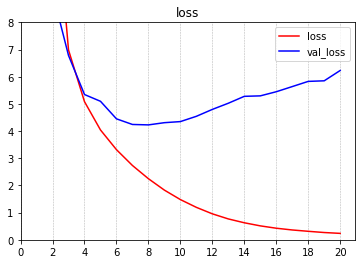

In [35]:
plt.plot(range(1, EPOCHS+1), history.history['loss'], 'r', label='loss')
plt.plot(range(1, EPOCHS+1), history.history['val_loss'], 'b', label='val_loss')
plt.title('loss')
plt.ylim(0, 8)
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 21, 2))
plt.legend()
plt.show()

9회부터 val_loss가 상승함
- overfitting이 일어났다고 판단됨

In [36]:
checkpoint_path = 'model/model_checkpoint.hdf5'

model.load_weights(checkpoint_path)

## Test Dataset

In [34]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
checkpoint_path = 'model/model_checkpoint.hdf5'
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = tf.keras.Model(inputs=input_data, outputs=y_pred)

In [35]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

Result: 	 SLINKING9999999999999999


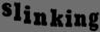

Result: 	 ALEPPO99999999999999999


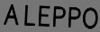

Result: 	 RWANDE999999999999999999


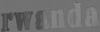

Result: 	 NATHANS99999999999999999


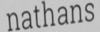

Result: 	 HALAS9999999999999999999


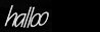

Result: 	 HURLS9999999999999999999


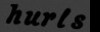

Result: 	 DOWNSIZE9999999999999999


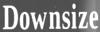

Result: 	 ROBOTIC99999999999999999


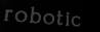

Result: 	 STOPPY99999999999999999


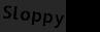

Result: 	 HERMITE99999999999999999


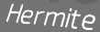

In [36]:
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

- 마지막에 왜 "999"가 반복이 될까?
- rwanda, halloo는 예측이 틀림

## Detect Text (sample image)

In [14]:
HOME_DIR = '/aiffel'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

In [15]:
detector = keras_ocr.detection.Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


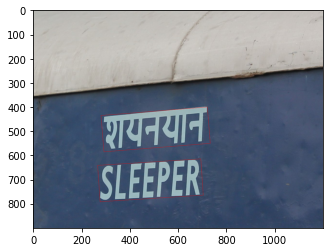

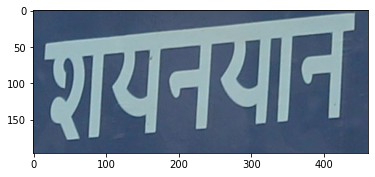

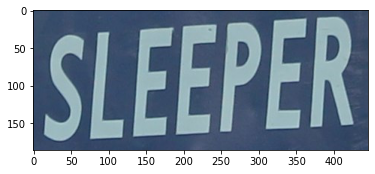

In [16]:
def detect_text(img_path):
    img_pil = PIL.Image.open(img_path)
    img_array = np.array(img_pil)
    
    img_array = np.expand_dims(img_array, axis=0)
    ocr_result = detector.detect(img_array)[0]
    
    result_img = img_pil.copy()
    img_draw = PIL.ImageDraw.Draw(result_img)

    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)

plt.imshow(img_pil)
plt.show()

for img in cropped_img:
    plt.imshow(img)
    plt.show()

## Text Recognition predict

In [17]:
def get_recognition_model(checkpoint_path='model/model_checkpoint.hdf5'):
    model = build_crnn_model()
    model.load_weights(checkpoint_path)

    input_data = model.get_layer('input_image').output
    y_pred = model.get_layer('output').output
    model_pred = tf.keras.Model(inputs=input_data, outputs=y_pred)
    return model_pred

model_pred = get_recognition_model()
model_pred.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 32, 3)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 32, 64)       1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 8, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 8, 256)        295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 8, 256)        5900

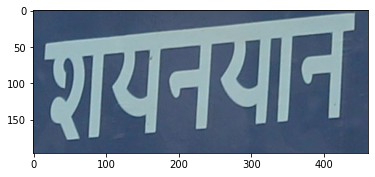

Result: URAGRIA99999999999999999


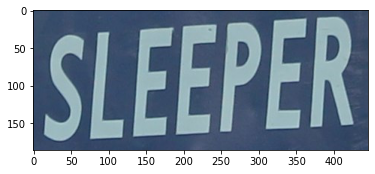

Result: SLEEPER9999999999999999


In [42]:
def recognize_img(img, input_img_size=(100,32)):
    img = np.array(img)

    height, width = img.shape[:2]
    target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
    target_img_size = (target_width, input_img_size[1])
    img = np.array(cv2.resize(img, target_img_size)).transpose(1,0,2)
    resize_image = np.zeros([*input_img_size, 3])
    resize_image[:img.shape[0], :, :] = img
    
    resize_image = np.expand_dims(resize_image, axis=0)
    output = model_pred.predict(resize_image)

    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result:", result)
    
for img in cropped_img:
    plt.imshow(img)
    plt.show()
    recognize_img(img)